xmin = [ 2.00000005 -1.        ]
fmin = 2.3680016131711013e-15
iterations = 5


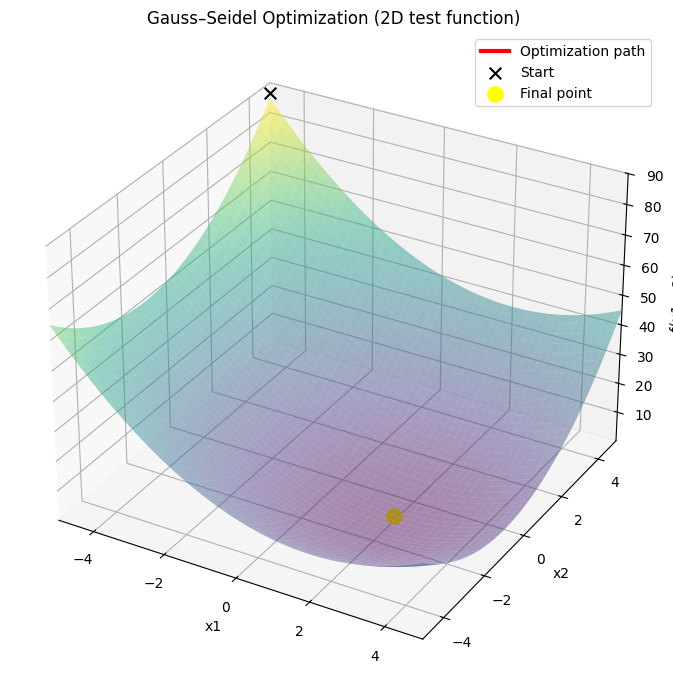

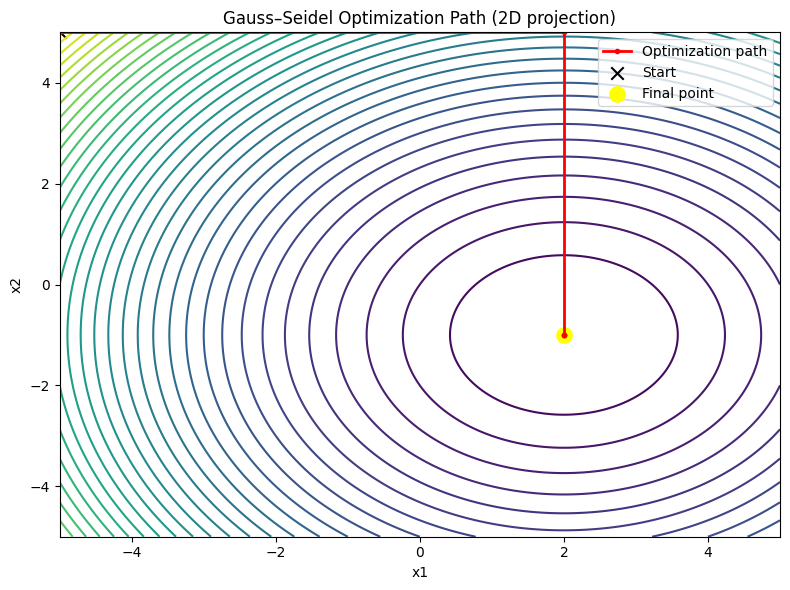

In [4]:
from test_functions import f_test1
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


def golden_section_search(f, a, b, delta_min, max_iter=10000):
    epsilon = (3.0 - np.sqrt(5.0)) / 2.0

    x1 = a + epsilon * (b - a)
    x2 = b - epsilon * (b - a)

    f1 = f(x1)
    f2 = f(x2)

    it = 0
    while (b - a) > delta_min and it < max_iter:
        it += 1

        if f1 < f2:
            b = x2
            x2 = x1
            f2 = f1
            x1 = a + epsilon * (b - a)
            f1 = f(x1)
        else:
            a = x1
            x1 = x2
            f1 = f2
            x2 = b - epsilon * (b - a)
            f2 = f(x2)

    x_min = 0.5 * (a + b)
    f_min = f(x_min)
    return x_min, f_min


def gauss_seidel_optimization(f, x0, eps=1e-6, interval=(-5, 5), max_outer_iters=1000):
    x = np.array(x0, dtype=float)
    history = [x.copy()]

    outer_iter = 0
    delta = eps + 1.0

    while delta > eps and outer_iter < max_outer_iters:
        x_old = x.copy()

        for i in range(len(x)):
            def f1d(t, i=i):
                xt = x.copy()
                xt[i] = t
                return f(xt)

            xi, _ = golden_section_search(f1d, interval[0], interval[1], delta_min=eps)
            x[i] = xi
            history.append(x.copy())

        delta = np.linalg.norm(x - x_old)
        outer_iter += 1

    return x, float(f(x)), np.array(history)


f_test = f_test1
start_point = [-5, 5]
search_interval = (-5, 5)
eps = 1e-6

xmin, fmin, history = gauss_seidel_optimization(
    f_test, x0=start_point, eps=eps, interval=search_interval
)

print("xmin =", xmin)
print("fmin =", fmin)
print("iterations =", len(history))


xg = np.linspace(search_interval[0], search_interval[1], 250)
yg = np.linspace(search_interval[0], search_interval[1], 250)
X, Y = np.meshgrid(xg, yg)

f_vec = np.vectorize(lambda xx, yy: f_test(np.array([xx, yy], dtype=float)))
Z = f_vec(X, Y).astype(float)

xs = history[:, 0].astype(float)
ys = history[:, 1].astype(float)
zs = np.array([f_test(np.array([x, y], dtype=float)) for x, y in zip(xs, ys)], dtype=float)

z_offset = 0.02 * (Z.max() - Z.min())
zs_plot = zs + z_offset
fmin_plot = fmin + z_offset


fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(X, Y, Z, cmap="viridis", alpha=0.45, linewidth=0)

line, = ax.plot([], [], [], color="red", lw=3, label="Optimization path")
point, = ax.plot([], [], [], "ro", markersize=6)

ax.scatter(xs[0], ys[0], zs_plot[0], color="black", s=70, marker="x", label="Start")
ax.scatter(xmin[0], xmin[1], fmin_plot, color="yellow", s=120, label="Final point")

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("f(x1, x2)")
ax.set_title("Gauss–Seidel Optimization (2D test function)")
ax.legend()

ax.set_xlim(xg.min(), xg.max())
ax.set_ylim(yg.min(), yg.max())
ax.set_zlim(Z.min(), Z.max() + 3 * z_offset)


def init():
    line.set_data([], [])
    line.set_3d_properties([])
    point.set_data([], [])
    point.set_3d_properties([])
    return line, point


def update(frame):
    line.set_data(xs[:frame + 1], ys[:frame + 1])
    line.set_3d_properties(zs_plot[:frame + 1])

    point.set_data([xs[frame]], [ys[frame]])
    point.set_3d_properties([zs_plot[frame]])
    return line, point


anim = FuncAnimation(
    fig,
    update,
    frames=len(xs),
    init_func=init,
    interval=200,
    blit=False,
    repeat=False
)

plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
plt.contour(X, Y, Z, levels=35)
plt.plot(xs, ys, "r-o", markersize=3, linewidth=2, label="Optimization path")
plt.scatter(xs[0], ys[0], color="black", marker="x", s=80, label="Start")
plt.scatter(xmin[0], xmin[1], color="yellow", s=120, label="Final point")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Gauss–Seidel Optimization Path (2D projection)")
plt.legend()
plt.tight_layout()
plt.show()
